# Two level systems
We will use the [Wikipedia](https://en.wikipedia.org/wiki/Maxwell–Bloch_equations) form of the optical Bloch equations:
\begin{gather}
\dot{\rho}_{gg}=\Gamma\rho_{ee}+\frac{\mathrm{i}}{2}\left(\Omega^*\tilde{\rho}_{eg}-\Omega\tilde{\rho}_{ge}\right)\\
\dot{\rho}_{ee}=-\Gamma\rho_{ee}+\frac{\mathrm{i}}{2}\left(\Omega\tilde{\rho}_{ge}-\Omega^*\tilde{\rho}_{eg}\right)\\
\dot{\tilde{\rho}}_{ge}=-\left(\frac{\Gamma}{2}+\mathrm{i}\delta\right)\tilde{\rho}_{ge}+\frac{\mathrm{i}}{2}\Omega^*\left(\rho_{ee}-\rho_{gg}\right)\\
\dot{\tilde{\rho}}_{eg}=-\left(\frac{\Gamma}{2}-\mathrm{i}\delta\right)\tilde{\rho}_{eg}+\frac{\mathrm{i}}{2}\Omega\left(\rho_{gg}-\rho_{ee}\right),\\
\end{gather}
where $\tilde{\rho}_{eg}=\rho_{eg}\mathrm{e}^{\mathrm{i}\delta t}$, $\tilde{\rho}_{ge}=\rho_{ge}\mathrm{e}^{-\mathrm{i}\delta t}$, $\Gamma$ is the natural linewidth, $\Omega$ is the Rabi frequency and $\delta=\omega-\omega_0$ is the laser detuning. 

In [6]:
using DifferentialEquations: ODEProblem, solve
using Plots: plot

function solve_obe_2level(Ω, Δ, tspan, u0; stepsize=0.02)
    # all frequencies are in unit of Γ, and time is in unit of 1/Γ
    # Ω = 1
    # δ = -1

    p = [Ω, Δ]

    # elements in du and u are in order of ρ_gg, ρ_ee, ρ_ge, ρ_eg
    function obe!(du, u, p, t)
        Ω = p[1]
        Δ = p[2]
        du[1]=u[2]+im/2*(conj(Ω)*u[4]-Ω*u[3])
        du[2]=-u[2]+im/2*(Ω*u[3]-conj(Ω)*u[4])
        du[3]=-(1/2+im*Δ)*u[3]+im/2*conj(Ω)*(u[2]-u[1])
        du[4]=-(1/2-im*Δ)*u[4]+im/2*Ω*(u[1]-u[2])
    end

    prob = ODEProblem(obe!, u0, tspan, p, saveat=stepsize)
    sol = solve(prob)

    return sol
end

solve_obe_2level (generic function with 1 method)

 15.207996 seconds (17.68 M allocations: 874.584 MiB, 1.72% gc time)


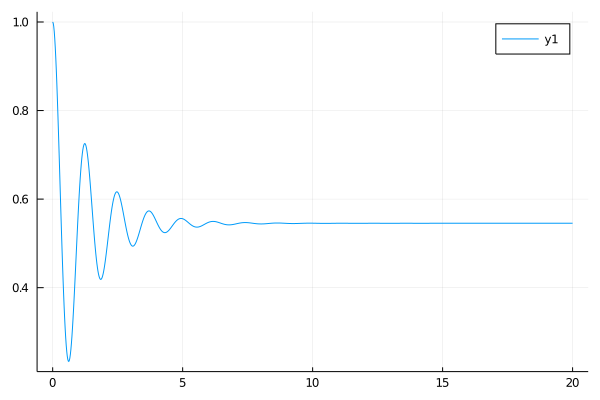

In [7]:
begin
    Ω = 5.0
    Δ = -1.0
    tspan = (0.0, 20.0)
    u0 = [1.0+0im, 0.0+0im, 0.0+0im, 0.0+0im]
    @time sol = solve_obe_2level(Ω, Δ, tspan, u0, stepsize=0.02)
    ρ_gg = [real(sol.u[i][1]) for i in 1:length(sol.t)]
    ρ_ee = [real(sol.u[i][2]) for i in 1:length(sol.t)]
    # plot(sol.t, [ρ_gg ρ_ee], label=["ρ_gg" "ρ_ee"])
    plot(sol.t, ρ_gg)
end

# Zeeman Sublevels

References:
1. [MIT course notes](https://ocw.mit.edu/courses/nuclear-engineering/22-51-quantum-theory-of-radiation-interactions-fall-2012/lecture-notes/MIT22_51F12_Ch8.pdf)
2. [Lukin notes](https://lukin.physics.harvard.edu/files/lukin/files/physics_285b_lecture_notes.pdf), derived for atomic system in thermal photon bath, take photon number to be 0, because room temperature don't really excite optical frequency photons
3. [python package: Qutip](https://qutip.org/docs/latest/guide/dynamics/dynamics-master.html)
4. [Wikipedia](https://en.wikipedia.org/wiki/Lindbladian)
5. Daniel Steck, quantum optics notes
6. [Tarbutt simulation](https://iopscience.iop.org/article/10.1088/1367-2630/18/12/123017)

We follow Tarbutt simulation here

In [5]:
using DifferentialEquations: ODEProblem, solve
using Plots: plot
using WignerSymbols: wigner3j, wigner6j

function solve_obe_zeeman(Ω, Δ, Fprime, F, u0; tspan=(0, 20), stepsize=0.02)
    # all frequencies are in unit of Γ, and time is in unit of 1/Γ
    # Ω = 1
    # δ = -1

    p = [Ω, Δ]
    
    function ε(q)
        q == 1 && return 0
        q == -1 && return 0
        q == 0 && return 1

        error("undefined component of electric field.")
    end

    function Ωpartial(q, n)
        (abs(n + q) > Fprime) && return 0
        (abs(n) > F) && return 0
        return im*Ω/2*ε(-q)*((-1)^(F-n))*wigner3j(F, 1, Fprime, -n, -q, n+q)
    end
    
    function Γpartial(q, m, n)
        (abs(m + q) > Fprime) && return 0
        (abs(n + q) > Fprime) && return 0
        (abs(m) > F) && return 0
        (abs(n) > F) && return 0
        return (2Fprime+1)*((-1)^(-m-n))*wigner3j(F, 1, Fprime, -m, -q, m+q)*wigner3j(F, 1, Fprime, -n, -q, n+q)
    end

    # elements in du and u are in order of ρ_gg, ρ_ee, ρ_ge, ρ_eg
    function obe!(du, u, p, t)
        Ω = p[1]
        Δ = p[2]
        
        for m in -F:F, n in -F:F
            mm = m + F + 1
            nn = n + F + 1
            du[mm, nn] = 0
            for q in -1:1
                (2F+1)+nn+q > 2F+2Fprime+2 && continue
                (2F+1)+mm+q > 2F+2Fprime+2 && continue
                du[mm,nn] += -conj(Ωpartial(q, n))*u[mm,(2F+1)+nn+q] - Ωpartial(q, m)*u[(2F+1)+mm+q,nn] + Γpartial(q, m, n)*u[(2F+1)+mm+q,(2F+1)+nn+q]
            end
        end
        
        for m in -Fprime:Fprime, n in -Fprime:Fprime
            mm = m + Fprime + 1
            nn = n + Fprime + 1
            du[(2F+1)+mm, (2F+1)+nn] = 0
            for q in -1:1
                mm-q < 1 && continue
                nn-q < 1 && continue
                du[(2F+1)+mm,(2F+1)+nn] += conj(Ωpartial(q, m-q))*u[mm-q,(2F+1)+nn] + Ωpartial(q, n-q)*u[(2F+1)+mm,nn-q] 
            end
            du[(2F+1)+mm,(2F+1)+nn] += -u[(2F+1)+mm,(2F+1)+nn]
        end
        
        for m in -F:F, n in -Fprime:Fprime
            mm = m + F + 1
            nn = n + Fprime + 1
            du[mm, (2F+1)+nn] = 0
            for q in -1:1
                (2F+1)+mm+q > 2F+2Fprime+2 && continue
                nn-q < 1 && continue
                du[mm,(2F+1)+nn] += Ωpartial(q, n-q)*u[mm,nn-q] - Ωpartial(q, m)*u[(2F+1)+mm+q,(2F+1)+nn] 
            end
            du[mm,(2F+1)+nn] += (im*Δ-1/2)*u[mm,(2F+1)+nn]
        end
        
        for m in -Fprime:Fprime, n in -F:F
            mm = m + Fprime + 1
            nn = n + F + 1
            du[(2F+1)+mm, nn] = conj(du[nn, (2F+1)+mm])
        end
    end

    prob = ODEProblem(obe!, u0, tspan, p, saveat=stepsize)
    sol = solve(prob)

    return sol
end

solve_obe_zeeman (generic function with 1 method)

In [22]:
begin
    Ω = 5.0
    Δ = -1.0
    F = 1
    Fprime = 2
    tspan = (0.0, 10.0)
    u0 = zeros((2F+2Fprime+2, 2F+2Fprime+2))
    for m in 1:2F+1
        u0[m,m] = 1/(2F+1)
    end
    @time sol = solve_obe_zeeman(Ω, Δ, Fprime, F, u0, tspan=tspan, stepsize=0.02)
    ρ_gg = [real(sol.u[i][1]) for i in 1:length(sol.t)]
    # ρ_ee = [real(sol.u[i][2]) for i in 1:length(sol.t)]
    # plot(sol.t, [ρ_gg ρ_ee], label=["ρ_gg" "ρ_ee"])
    plot(sol.t, ρ_gg)
end

LoadError: [91mInexactError: Float64(0.0 - 0.26352313834736496im)[39m

In [58]:
Float64(1+im)

LoadError: [91mInexactError: Float64(1 + 1im)[39m

In [21]:
a = [1 2; 3 4]
a[5]

LoadError: [91mBoundsError: attempt to access 2×2 Array{Int64,2} at index [5][39m